In [1]:
from PIL import Image, ImageOps
import numpy as np
from matplotlib import pyplot as plt
import json
import numpy as np
from numpy import random as rd

In [2]:
def get_other_axis(x,xrate,yrate):
    return int(round((x*yrate)/xrate))

def makeline(xs, ys, xd, yd):
    ydist = yd-ys
    xdist = xd-xs
    longest = max(ydist,xdist)
    ymove = 0 if ydist==0 or longest==0 else ydist/longest
    xmove = 0 if xdist==0 or longest==0 else xdist/longest
    xo = xs
    yo = ys
    outx = []
    outy = []
    for i in range(longest):
        xo += xmove
        yo += ymove
        outx.append(int(round(xo)))
        outy.append(int(round(yo)))
    return outx, outy

def makesquare(x0, y0, x1, y1):
    hline = [x for x in range(x0,x1+1)]
    vline = [y for y in range(y0,y1+1)]
    hztop = [y0 for _ in hline]
    hzbot = [y1 for _ in hline]
    vzlef = [x0 for _ in vline]
    vzrig = [x1 for _ in vline]
    
    xout = hline + vzlef + hline + vzrig
    yout = hztop + vline + hzbot + vline
    
    return xout,yout

In [3]:
def define_path_vars():
    global db_dir, dump_dir, out_dir, img_dir, db_specifics
    path_file = open('PATH.json')
    path_set = json.load(path_file)
    db_dir = path_set['db_dir']
    dump_dir = path_set['dump_dir']
    out_dir = path_set['out_dir']
    img_dir = path_set['img_dir']
    db_specifics = path_set['db_specifics']
    path_file.close()
    
define_path_vars()

In [4]:
class Bottle:
    def __init__(self, name, image=None, settings=None):
        self.name = name
        self.cuts, self.parts = settings if settings else json.load(open(f'{name}.json'))
        self.image = image if image else Image.open(f'{name}.jpg')
        
    def get_image_parts(self):
        output = []
        max_y = self.cuts[0][0]
        for i in range(len(self.parts)):
            min_x, max_x = self.parts[i]['range']
            min_y, max_y = max_y, self.cuts[i+1][0]
            
            # Relative Horizontal Cut x Positioning
            tc0, tc1 = self.cuts[i][1:] # Actual top cut points
            bc0, bc1 = self.cuts[i+1][1:] # Actual bottom cut points
            top_min_cut = tc0 - min_x
            top_max_cut = tc1 - min_x
            bottom_min_cut = bc0 - min_x
            bottom_max_cut = bc1 - min_x
            
            output.append((
                self.image.crop((min_x, min_y, max_x, max_y)),
                (self.name, self.parts[i]['name']),
                ((top_min_cut, top_max_cut), (bottom_min_cut, bottom_max_cut))
            ))
        return output
    
    def analysis_image(self):
        out = np.array(self.image)
        y1, bc0, bc1 = self.cuts[0]
        for i in range(len(self.parts)):
            y0, tc0, tc1 = y1, bc0, bc1
            y1, bc0, bc1 = self.cuts[i+1]
            x0, x1 = self.parts[i]['range']
            lx, ly = makeline(tc0,y0,bc0,y1)
            rx, ry = makeline(tc1,y0,bc1,y1)
            sqx, sqy = makesquare(x0,y0,x1,y1)
            out[ly,lx] = [0,0,255]
            out[ry,rx] = [0,0,255]
            out[sqy,sqx] = [0,255,0]
        return Image.fromarray(out)

In [5]:
def get_bottle_image(name):
    return Image.open(f'{db_dir}/{img_dir}/{name}.jpg')

def get_bottle_settings(name):
    settings_file = open(f'{db_dir}/json/cutinfo/{name}.json')
    cuts, parts = json.load(settings_file)
    settings_file.close()
    return [cuts, parts]

def init_bottles(names):
    global bottles
    bottles = [Bottle(name, get_bottle_image(name), get_bottle_settings(name)) for name in names]
    return bottles

def init_bottles_from_catalogue():
    global bottles
    names = open(f'{db_dir}/json/catalog.json')
    bottles = init_bottles(json.load(names))
    return bottles

In [6]:
init_bottles_from_catalogue()

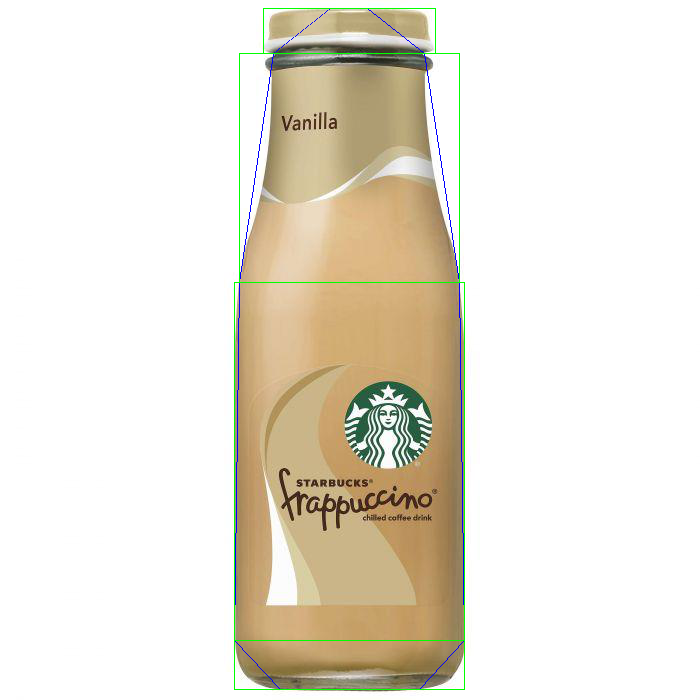

In [7]:
bottles[-1].analysis_image()

In [8]:
def part_classify(bottles_data_structure):
    global caps, mids, bottoms
    bottle_parts_data_structure = [x.get_image_parts() for x in bottles_data_structure]
    caps = [x[0] for x in bottle_parts_data_structure]
    bottoms = [x[-1] for x in bottle_parts_data_structure]
    mids = []
    for bottle_parts in bottle_parts_data_structure:
        for part in bottle_parts[1:-1]:
            mids.append(part)
    return caps, mids, bottoms

In [9]:
part_classify(bottles)

([(<PIL.Image.Image image mode=RGB size=150x120 at 0x7FBC69E16BA8>,
   ('tebs', 'cap'),
   ((0, 150), (15, 135))),
  (<PIL.Image.Image image mode=RGB size=98x150 at 0x7FBC3E9C6668>,
   ('saori', 'cap'),
   ((35, 59), (9, 93))),
  (<PIL.Image.Image image mode=RGB size=64x40 at 0x7FBC69DB3208>,
   ('dasani', 'cap'),
   ((4, 62), (10, 58))),
  (<PIL.Image.Image image mode=RGB size=48x37 at 0x7FBC69DB36D8>,
   ('tehpucuk', 'cap'),
   ((8, 41), (4, 45))),
  (<PIL.Image.Image image mode=RGB size=307x166 at 0x7FBC69DB34E0>,
   ('downy', 'cap'),
   ((50, 272), (16, 293))),
  (<PIL.Image.Image image mode=RGB size=207x91 at 0x7FBC69DB3828>,
   ('tenga', 'topend'),
   ((61, 145), (0, 207))),
  (<PIL.Image.Image image mode=RGB size=815x143 at 0x7FBC69DB3B00>,
   ('aibon', 'cap'),
   ((317, 455), (17, 803))),
  (<PIL.Image.Image image mode=RGB size=67x46 at 0x7FBC69DB3C50>,
   ('big mountain dew', 'cap'),
   ((27, 39), (5, 62))),
  (<PIL.Image.Image image mode=RGB size=781x203 at 0x7FBC69DB3E80>,
 

In [10]:
def bottle_append_two(parts):
    # Parts is a data structure, a list of:
    # > The PIL.Image object
    # > Tuple of bottle name and part name
    # > Tuple of:
    #   > tuple of top cut relative x positions
    #   > tuple of bottom cut relative x positions
    # Size can be obtained uising PIL.Image.size
    
    # PROTOTYPE: ONLY FOR TWO PARTS!
    
    # Prep
    #endproducts = [parts[0][0]]
    bc0, bc1 = parts[0][-1][1] # Bottom cut points of first part
    tc0, tc1 = parts[1][-1][0] # Top cut points of second part
    scale = (bc1-bc0)/(tc1-tc0) # Scale factor
    b_x, b_y = parts[0][0].size # Original size of first part
    t_x, t_y = parts[1][0].size # Original size of second part
    t_x_postscale = int(round(t_x*scale))
    t_y_postscale = get_other_axis(t_x_postscale,t_x,t_y)
    tc0_postscale = int(round(tc0*scale))
    tc1_postscale = int(round(tc1*scale))
    image_postscale = parts[1][0].resize((t_x_postscale, t_y_postscale))
    
    # We have to check if the second part is larger post scaling and
    # translation both on left and right to finally able to decide the
    # size of the image.
    #
    # In the case of we have translate > 0, the second part is moved to
    # the right. Case of translate < 0, the first part is moved to the
    # right instead.
    #
    # After such translations, it is easier to count final horizontal
    # size of the new image, which is
    # max(b1_postranslate, t1_postscale_postranslate)
    
    translate = bc0-tc0_postscale
    t_b = -min(0, translate)
    t_t = max(0, translate)
    # Fuck yeah no if conditionals used
    
    b0_pt, bc0_pt, bc1_pt, b1_pt = t_b, bc0+t_b, bc1+t_b, b_x+t_b
    t0_pt, tc0_pt, tc1_pt, t1_pt = t_t, tc0_postscale+t_t, tc1_postscale+t_t, t_x_postscale+t_t
    
    h_size = max(b1_pt, t1_pt)
    v_size = b_y + t_y_postscale
    
    out_canvas = np.zeros((v_size,h_size,3),dtype='uint8')
    out_canvas[:,:,:] = 255
    out_canvas[0:b_y,b0_pt:b1_pt,:] = np.array(parts[0][0])
    out_canvas[b_y:,t0_pt:t1_pt,:] = np.array(image_postscale)
    
    # For new result cut point metadata
    n_tc0, n_tc1 = parts[0][-1][0] # Top cut points of first part
    n_bc0, n_bc1 = parts[1][-1][1] # Bottom cut points of second part
    n_tc0, n_tc1 = n_tc0+t_b, n_tc1+t_b
    n_bc0, n_bc1 = int(round(n_bc0*scale))+t_t, int(round(n_bc1*scale))+t_t
    
    return [
        Image.fromarray(out_canvas),
        (f'{parts[0][1][0]}-{parts[1][1][0]}', f'{parts[0][1][1]}-{parts[1][1][1]}'),
        ((n_tc0, n_tc1), (n_bc0, n_bc1))
    ]

def bottle_append(parts):
    # Parts is a list of a data structure, a list of:
    # > The PIL.Image object
    # > Tuple of bottle name and part name
    # > Tuple of:
    #   > tuple of top cut relative x positions
    #   > tuple of bottom cut relative x positions
    # Size can be obtained uising PIL.Image.size
    
    appended = parts[0]
    for part in parts[1:]:
        appended = bottle_append_two((appended,part))
    return appended

def flip(part):
    return [ImageOps.flip(part[0]), (part[1][0],f'{part[1][1]} (flip)'), (part[-1][1], part[-1][0])]

In [11]:
def random_pick_parts(
    n=None,
    n_min=2,
    n_max=6,
    #cap=2,
    #bot=2,
    #cap_excl=2,
    #bot_excl=2,
    flip_enabled=1):
    """
    if n is not set, it will choose n between [n_min, n_max].
    
    cap and bot governs should the bottle use caps
    and bottoms respectively. If false, respective
    part will use the parts
    
    cap_excl and bot_excl governs should a cap or bottom
    respectively only available on their appropriate position
    (i.e. cap on top, bottom on bottom).
    Ignored if its respective param (cap or bot) is disabled.
    If enabled, 
    
    Integer values on last four params means:
    0 is False
    1 is True
    2 randomize between False and True
    
    Future params:
    
    FUCK DUDE I AM SO DONE WITH DOCUMENTATIONS
    Ok so, so far the randomizer will only pick cap, bottom,
    and the rest is the mids.
    """
    if not n: n = rd.randint(n_min,n_max+1)
    picks = [rd.permutation(caps)[0]]
    for i in range(n-2):
        if rd.permutation([0,flip_enabled])[0]:
            picks.append(flip(rd.permutation(mids)[0]))
        else:
            picks.append(rd.permutation(mids)[0])
    picks.append(rd.permutation(bottoms)[0])
    return picks
    
def super_random_bottle():
    picks = random_pick_parts()
    return bottle_append(picks), picks

def get_ingredients_as_str(picks):
    return 'Parts used:\n'+'\n'.join([f'{pick[1][0]} - {pick[1][1]}' for pick in picks])

def get_fusion_name(picks):
    return ''.join([p[1][0][i%len(p[1][0])] for i, p in enumerate(picks)])

to
Parts used:
tehbotol - captop
pocari500ml - bottom


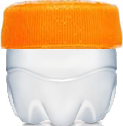

In [19]:
finbot = super_random_bottle()
print(get_fusion_name(finbot[1]))
print(get_ingredients_as_str(finbot[1]))
finbot[0][0]